1. 使用`core.surface`模块生成材料的各种slabs;    
2. 结合不同指数晶面的表面能, 获得伍尔夫形状(Wulff shape)

[Surface Energies of Elemental Crystals](https://www.nature.com/articles/sdata201680)    
[Efficient creation and convergence of surface slabs](https://www.sciencedirect.com/science/article/pii/S003960281300160X)

In [1]:
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, Structure, Lattice
from pymatgen.analysis.wulff import WulffShape

## 生成slabs

In [2]:
lattice = Lattice.cubic(3.508)
Ni = Structure(lattice, ["Ni", "Ni", "Ni", "Ni"], [[0,0,0], [0,0.5,0], [0.5,0,0], [0,0,0.5]])
print(Ni)

Full Formula (Ni4)
Reduced Formula: Ni
abc   :   3.508000   3.508000   3.508000
angles:  90.000000  90.000000  90.000000
Sites (4)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ni    0    0    0
  1  Ni    0    0.5  0
  2  Ni    0.5  0    0
  3  Ni    0    0    0.5


In [3]:
slabgen = SlabGenerator(Ni, (1,1,1), 10, 10)
print(type(slabgen))

<class 'pymatgen.core.surface.SlabGenerator'>


In [4]:
# there should only be one way to cut a (111) slab.
all_slabs = slabgen.get_slabs() 
print("The Ni(111) slab only has {} termination.".format(len(all_slabs) ))

The Ni(111) slab only has 1 termination.


In [5]:
# Let's try this for a diamond Silicon structure
lattice = Lattice.cubic(5.46873)
Si = Structure(lattice, ["Si", "Si", "Si", "Si", 
                         "Si", "Si", "Si", "Si"],
               [[0.00000, 0.00000, 0.50000],
                [0.75000, 0.75000, 0.75000],
                [0.00000, 0.50000, 0.00000],
                [0.75000, 0.25000, 0.25000],
                [0.50000, 0.00000, 0.00000],
                [0.25000, 0.75000, 0.25000],
                [0.50000, 0.50000, 0.50000],
                [0.25000, 0.25000, 0.75000]])
print(Si)

Full Formula (Si8)
Reduced Formula: Si
abc   :   5.468730   5.468730   5.468730
angles:  90.000000  90.000000  90.000000
Sites (8)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0.5
  1  Si    0.75  0.75  0.75
  2  Si    0     0.5   0
  3  Si    0.75  0.25  0.25
  4  Si    0.5   0     0
  5  Si    0.25  0.75  0.25
  6  Si    0.5   0.5   0.5
  7  Si    0.25  0.25  0.75


In [6]:
slabgen = SlabGenerator(Si, (1,1,1), 10, 10)
print("there are actually now {} terminations for Si-(111)".format(len(slabgen.get_slabs()) ))

there are actually now 2 terminations for Si-(111)


In [7]:
# generate_all_slabs: finds all the unique Miller indices; SlabGenerator: create all terminations 
all_slabs = generate_all_slabs(Si, 3, 10, 10)
print("{} unique slab structures have been found for a max Miller index of 3".format((len(all_slabs)) ))

18 unique slab structures have been found for a max Miller index of 3


In [8]:
# What are the Miller indices of these slabs?
for slab in all_slabs:
    print(slab.miller_index, end='; ')
%kk 10#
print("Notice some Miller indices are repeated. Again, this is due to there being more than one termination")

(1, 1, 1); (1, 1, 1); (3, 3, 2); (3, 3, 1); (3, 3, 1); (1, 1, 0); (3, 2, 2); (3, 2, 2); (3, 2, 1); (3, 2, 0); (3, 1, 1); (3, 1, 1); (3, 1, 0); (1, 0, 0); (2, 2, 1); (2, 2, 1); (2, 1, 1); (2, 1, 0); ##########
Notice some Miller indices are repeated. Again, this is due to there being more than one termination


## Wulff shape的基本性质

**weighted_surface_energy**: 由表面积加权的表面能;   
晶体的表面吉布斯自由能(Surface Gibbs free energy): $\large \Delta G=\sum\limits_{hkl}\gamma_{hkl}A_{hkl}$    
使用Wulff形状的总面积归一化表面能: $\large \bar{\gamma}=\frac{\Delta G}{\sum\limits_{hkl}A_{hkl}}$    
* $\gamma_{hkl}$: hkl晶面的表面能;    
* $A_{hkl}$: 占据wulff形状的特定表面的表面积;   
* $\sum\limits_{hkl}A_{hkl}$: Wulff形状的总面积;

**anisotropy**: 各向异性;    
各向异性的度量:  
* 当提及表面的各向异性, 通常涉及`两个晶面能的比值`: $E_{111} / E_{100} <1 $; (111)表面能最小, (100)的表面能最大;   
* 也可以使用加权表面能的`变异系数`(Coefficient of Variation)来度量多个表面之间的变化, 作为参考(for reference), 理想球形(各向同性)的Wulff体的变异系数为0; 

**shape_factor**: 形状因子;   

各向异性的替代方案, 这对于确定临界核尺寸很有用, 大的形状因子表明很大的各向异性;    
`See Ballufi, R. W., Allen, S. M. & Carter, W. C. Kinetics of Materials. (John Wiley & Sons, 2005), p.461`

In [9]:
# Surface energy values in J/m^2
surface_energies_Ni = {(3, 2, 0): 2.3869, (1, 1, 0): 2.2862, 
                       (3, 1, 0): 2.3964, (2, 1, 0): 2.3969, 
                       (3, 3, 2): 2.0944, (1, 0, 0): 2.2084, 
                       (2, 1, 1): 2.2353, (3, 2, 2): 2.1242, 
                       (3, 2, 1): 2.3183, (2, 2, 1): 2.1732, 
                       (3, 3, 1): 2.2288, (3, 1, 1): 2.3039, 
                       (1, 1, 1): 1.9235}

In [10]:
miller_list = surface_energies_Ni.keys()
e_surf_list = surface_energies_Ni.values()

使用最大弥勒指数'3'创建Wullf形状

In [11]:
wulffshape = WulffShape(Ni.lattice, miller_list, e_surf_list)

从Wulff对象提取信息

In [12]:
print("shape factor: {:.3f}, anisotropy: {:.3f}, weighted surface energy: {:.3f} J/m^2".format(
       wulffshape.shape_factor, wulffshape.anisotropy, wulffshape.weighted_surface_energy ))

shape factor: 5.178, anisotropy: 0.070, weighted surface energy: 2.035 J/m^2


沃夫形状可视化

C:\Users\tfliu\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


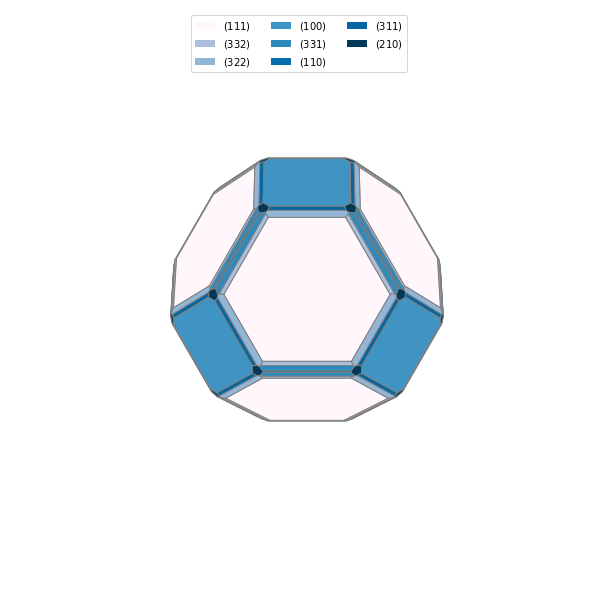

In [13]:
wulffshape.show()

## 表面能公式

$\gamma = \frac{E_{slab}-E_{bulk}}{2A}$:     
* $E_{bulk}$: 体相总能, 最好(preferably)是与slab对应的单位晶胞;    
* $E_{slab}$: slab总能, 几个原子层并且带有一个真空层;   
* 1/2: 一个slab包含两个表面;
* 使用条件: slab和bulk体系应包含相同数量的原子和物种;

获取`LiFePO4`的结构

In [14]:
from pymatgen.util.testing import PymatgenTest
LiFePO4 = PymatgenTest.get_structure("LiFePO4") 

In [15]:
print(LiFePO4)

Full Formula (Li4 Fe4 P4 O16)
Reduced Formula: LiFePO4
abc   :   4.744800   6.065770  10.410370
angles:  90.501790  90.000190  90.003620
Sites (28)
  #  SP          a        b        c
---  ----  -------  -------  -------
  0  Li    1e-05    0.99999  0.99999
  1  Li    0.99999  0.5      1e-05
  2  Li    0.49999  0.99999  0.5
  3  Li    0.50002  0.5      0.5
  4  Fe    0.52507  0.25344  0.21884
  5  Fe    0.02508  0.74654  0.28116
  6  Fe    0.97497  0.25346  0.71884
  7  Fe    0.47493  0.74653  0.78116
  8  P     0.58205  0.75169  0.09444
  9  P     0.08207  0.2483   0.40556
 10  P     0.91794  0.75174  0.59443
 11  P     0.41793  0.24828  0.90557
 12  O     0.29156  0.25112  0.04317
 13  O     0.25851  0.75043  0.09622
 14  O     0.71346  0.95594  0.1658
 15  O     0.71627  0.5486   0.16562
 16  O     0.21629  0.4514   0.33438
 17  O     0.21345  0.04406  0.33419
 18  O     0.75852  0.24955  0.40378
 19  O     0.79157  0.7489   0.45682
 20  O     0.20845  0.2511   0.54316
 21  O     0

考虑表面极性, 必须添加氧化态

In [16]:
LiFePO4.add_oxidation_state_by_element({"Fe": 2, "Li": 1, "P": 5, "O": -2})
print(LiFePO4)

Full Formula (Li4 Fe4 P4 O16)
Reduced Formula: LiFePO4
abc   :   4.744800   6.065770  10.410370
angles:  90.501790  90.000190  90.003620
Sites (28)
  #  SP          a        b        c
---  ----  -------  -------  -------
  0  Li+   1e-05    0.99999  0.99999
  1  Li+   0.99999  0.5      1e-05
  2  Li+   0.49999  0.99999  0.5
  3  Li+   0.50002  0.5      0.5
  4  Fe2+  0.52507  0.25344  0.21884
  5  Fe2+  0.02508  0.74654  0.28116
  6  Fe2+  0.97497  0.25346  0.71884
  7  Fe2+  0.47493  0.74653  0.78116
  8  P5+   0.58205  0.75169  0.09444
  9  P5+   0.08207  0.2483   0.40556
 10  P5+   0.91794  0.75174  0.59443
 11  P5+   0.41793  0.24828  0.90557
 12  O2-   0.29156  0.25112  0.04317
 13  O2-   0.25851  0.75043  0.09622
 14  O2-   0.71346  0.95594  0.1658
 15  O2-   0.71627  0.5486   0.16562
 16  O2-   0.21629  0.4514   0.33438
 17  O2-   0.21345  0.04406  0.33419
 18  O2-   0.75852  0.24955  0.40378
 19  O2-   0.79157  0.7489   0.45682
 20  O2-   0.20845  0.2511   0.54316
 21  O2-   0

In [17]:
slabgen = SlabGenerator(LiFePO4, (0,0,1), 10, 10)

生成LiFePO4的slab时,需要注意不能破坏P-O键, 这些键很强, 如果被断裂的话将要导致非常大的表面能;    
给slab添加键约束: 当生成slab时, P-O之间小于2埃的键都不可以断裂;

In [18]:
all_slabs = slabgen.get_slabs(bonds={("P", "O"): 2}) 
print("For the (001) slab of LiFePO4, there are {} terminations.".format( len(all_slabs) ))

For the (001) slab of LiFePO4, there are 5 terminations.


当计算表面能时, slabs必须同时满足两条准则: nonpolar, symmetric

In [19]:
for slab in all_slabs:
    print(slab.is_polar(), slab.is_symmetric())

True False
True False
True False
True False
False False


> **表面能计算时的注意事项**:    
1. **slab的两面必须完全相同**:     
slab模型不需具有`Laue point group symmetry`(inversion symmetry),使用slab的`is_symmetric()`属性检查; 如果slab不是对称的, 我们计算的是两个表面的平均能而不是单个表面的能量;  
2. **对于包含氧化态的结构, 我们需要保证表面是非极化的**:  
如果发生表面极化, 计算的表面能是相当大的, 使用slab的`is_polar()`属性查看;   
3. **001方向上的任何晶面都不满足计算条件**?    
修改slab: A **future release** of `surface.py`  will implement such modification techniques for these cases.

弥勒指数为3的情况下不能满足计算的条件, 将密勒指数改为2 

In [20]:
#take a while.
all_slabs = generate_all_slabs(LiFePO4, 2, 10, 10, bonds={("P", "O"): 2})

In [21]:
print("There is a total of <<{}>> slabs generated including polar, asymmetric, and P-O terminated slabs.".format(
                            len(all_slabs) ))

There is a total of <<210>> slabs generated including polar, asymmetric, and P-O terminated slabs.


将满足计算条件的所有结构保存

In [22]:
valid_slabs = []
for slab in all_slabs:
    if not slab.is_polar() and slab.is_symmetric():
        print(slab.miller_index)
        valid_slabs.append(slab)

(1, 0, 1)
(1, 2, 1)


In [23]:
print("Number of slabs that are nonpolar, symmetric and do not terminate P-O bonds: {}".format(len(valid_slabs)))

Number of slabs that are nonpolar, symmetric and do not terminate P-O bonds: 2
